## Data Analysis using BulkLMM - BXD Longevity Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
using Plots

In [3]:
local_path = "../../BulkLMM.jl/src";

## Load processed_data:

### By individuals:

In [4]:
BXD_pheno_ind_summary_df = CSV.read("data/GN886_pheno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 32445 livear proteome.

In [5]:
println(size(BXD_pheno_ind_summary_df)) 
BXD_pheno_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021
3,H2577,BXD9,9,12.415,10.487,17.89,17.488,17.594,16.731,16.208
4,H0365,BXD9,9,11.374,10.674,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.362,17.367,17.071,16.465,15.97
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.847,17.416,17.042,16.292
8,H1791,BXD24,24,12.5,12.273,17.944,17.833,17.63,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


In [6]:
BXD_geno_ind_summary_df = CSV.read("data/GN886_geno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 7321 markers.

In [7]:
println(size(BXD_geno_ind_summary_df)) 
BXD_geno_ind_summary_df[1:10, 1:10]

(248, 7324)


Row,Sample,Strain,Strain_num,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0370,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H2577,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0365,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,H1333,BXD13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,H2259,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,H1792,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,H1791,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,H1541,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### By strains:

In [8]:
BXD_pheno_strains_summary_df = CSV.read("data/GN886_pheno_strain_means_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 32445 liver proteome.

In [9]:
println(size(BXD_pheno_strains_summary_df)) 
BXD_pheno_strains_summary_df[1:10, 1:10]

(50, 32447)


Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98
3,BXD24,5,12.0778,11.7458,17.7926,17.8152,17.5168,16.9196,16.3012,16.4304
4,BXD27,3,11.717,11.149,17.336,17.3143,17.165,16.5283,15.9407,16.002
5,BXD29,11,11.735,11.3496,17.4583,17.3877,17.2431,16.4945,16.0869,16.1075
6,BXD32,8,11.6266,11.554,17.8254,17.7716,17.4639,16.9029,16.434,16.425
7,BXD34,13,11.7491,11.9135,17.6108,17.5974,17.2988,16.7761,16.3147,16.2926
8,BXD39,5,11.9158,11.719,17.395,17.385,17.157,16.5226,16.179,16.0594
9,BXD40,8,11.8651,11.6817,17.5986,17.6386,17.3861,16.6824,16.2855,16.2523


In [10]:
BXD_geno_strains_summary_df = CSV.read("data/GN886_geno_strains_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 7321 markers.

In [11]:
println(size(BXD_geno_strains_summary_df)) 
BXD_geno_strains_summary_df[1:10, 1:10]

(50, 7322)


Row,Strain,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BXD13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BXD24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BXD27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BXD29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,BXD32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BXD34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BXD39,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,BXD40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load functions:

In [12]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));

## Objectives

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

## Run BulkLMM.jl:

### Calculate kinship:

First, calculate the kinship matrix of relatedness among the strains (50-by-50):

In [13]:
geno_strains = Matrix{Float64}(BXD_geno_strains_summary_df[:, 2:end]);

In [14]:
kinship_strains = calcKinship(geno_strains);

Then, construct the kinship matrix of relatedness among the individuals based on which strain they are from:

In [15]:
function calcRepeats(x::Array{Int64, 1})
    
    counting_dict = Dict{Int64, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 1 method)

In [16]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [17]:
BXD_geno_ind_summary_df.Strain_num = Vector{Int64}(BXD_geno_ind_summary_df.Strain_num);

In [18]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_geno_ind_summary_df.Strain_num);

  0.000224 seconds (76 allocations: 503.766 KiB)


Compare the runtime with directly calculating the kinship matrix from individual genotype data:

In [19]:
geno_ind = Matrix{Float64}(BXD_geno_ind_summary_df[:, 4:end]);

In [20]:
@time kinship_ind_from_ind = calcKinship(geno_ind);

  3.066822 seconds (306.28 k allocations: 8.368 GiB, 5.70% gc time)


In [21]:
maximum(abs.(kinship_ind_from_ind .- kinship_ind_from_strains))

0.04186586531894554

### Single-trait genome scans:

To see single trait genome scan results, we take the 7512-th livear proteomic as the single trait to run analysis:  

In [22]:
lp_names = names(BXD_pheno_ind_summary_df)[4:end];

In [23]:
lp_id = 7512;
lp_names[lp_id]

"P61924_VALRGEDVPLTEQTVSQVLQSAK_3"

#### For individual liver proteome

In [24]:
lp_ind_Y = Matrix{Float64}(BXD_pheno_ind_summary_df[:, 4:end]);
lp_ind_y = reshape(lp_ind_Y[:, lp_id], :, 1);

In [25]:
@time scan_results_ind = scan(lp_ind_y, geno_ind, kinship_ind_from_strains);

  0.232972 seconds (80.92 k allocations: 134.882 MiB, 23.64% gc time)


In [26]:
@time scan_results_ind_alt = scan(lp_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt");

  4.312518 seconds (3.85 M allocations: 4.786 GiB, 7.77% gc time)


In [27]:
@time scan_perms_results_ind = scan(lp_ind_y, geno_ind, kinship_ind_from_strains;
                                    permutation_test = true, nperms = 1000, original = true);

  0.935073 seconds (1.94 M allocations: 261.029 MiB, 2.22% gc time, 84.62% compilation time)


#### For liver proteome means by strains

In [28]:
lp_strains_Y = Matrix{Float64}(BXD_pheno_strains_summary_df[:, 3:end]);
lp_strains_y = reshape(lp_strains_Y[:, lp_id], :, 1);

In [29]:
@time scan_results_strains = scan(lp_strains_y, geno_strains, kinship_strains);

  0.046014 seconds (82.15 k allocations: 32.632 MiB)


In [30]:
@time scan_results_strains_alt = scan(lp_strains_y, geno_strains, kinship_strains;
                                      assumption = "alt");

  3.845243 seconds (10.18 M allocations: 3.166 GiB, 9.18% gc time)


In [31]:
@time scan_perms_results_strains = scan(lp_strains_y, geno_strains, kinship_strains;
                                        permutation_test = true, nperms = 1000, original = true);

  0.034385 seconds (91.29 k allocations: 79.023 MiB)


### Multiple-trait genome scans:

In [32]:
BLAS.set_num_threads(16)

In [33]:
BLAS.get_num_threads()

16

In [34]:
grid_list = collect(0.0:0.05:0.95);

#### For individual liver proteome

In [35]:
@benchmark bulkscan_null_grid(lp_ind_Y, geno_ind, kinship_ind_from_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 5.167 s (9.29% GC) to evaluate,
 with a memory estimate of 11.67 GiB, over 10097531 allocations.

In [36]:
@time bulkscan_results_null_grid_ind = bulkscan_null(lp_ind_Y, geno_ind, kinship_ind_from_strains; nb = 16);

114.024189 seconds (2.60 G allocations: 1.813 TiB, 21.25% gc time, 0.06% compilation time)


In [37]:
BLAS.set_num_threads(16)

In [38]:
@benchmark bulkscan_alt_grid(lp_ind_Y, geno_ind, kinship_ind_from_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 20.440 s (3.71% GC) to evaluate,
 with a memory estimate of 41.84 GiB, over 8691549 allocations.

In [39]:
@time bulkscan_results_ind = bulkscan_null_grid(lp_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

  5.599795 seconds (10.10 M allocations: 11.669 GiB, 2.83% gc time)


#### For liver proteome means by strains

In [40]:
@benchmark bulkscan_null_grid(lp_strains_Y, geno_strains, kinship_strains, grid_list)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.587 s …    2.587 s  ┊ GC (min … max): 4.54% … 4.97%
 Time  (median):     2.587 s               ┊ GC (median):    4.76%
 Time  (mean ± σ):   2.587 s ± 242.161 μs  ┊ GC (mean ± σ):  4.76% ± 0.30%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.59 s         Histogram: frequency by time         2.59 s <

 Memory estimate: 5.30 GiB, allocs estimate: 9474505.

In [41]:
@time bulkscan_results_null_grid_strains = bulkscan_null(lp_strains_Y, geno_strains, kinship_strains);

 56.719207 seconds (2.61 G allocations: 434.463 GiB, 44.60% gc time)


In [42]:
BLAS.set_num_threads(16)

In [43]:
@benchmark bulkscan_alt_grid(lp_strains_Y, geno_strains, kinship_strains, grid_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 13.822 s (3.36% GC) to evaluate,
 with a memory estimate of 36.86 GiB, over 8691485 allocations.

In [44]:
@time bulkscan_results_strains = bulkscan_null_grid(lp_strains_Y, geno_strains, kinship_strains, grid_list);

  2.849914 seconds (9.47 M allocations: 5.301 GiB, 5.17% gc time)


In [45]:
scan_results_strains.h2_null

5.545009081338703e-16

In [46]:
hcat(scan_results_ind.lod, scan_results_strains.lod, 
     bulkscan_results_ind[3][:, lp_id], bulkscan_results_strains[3][:, lp_id]) |> 
(x -> DataFrame(x, ["LOD_ind", "LOD_strains", "LOD_ind_grid", "LOD_strains_grid"])) |> x -> x[1:10, :]

Row,LOD_ind,LOD_strains,LOD_ind_grid,LOD_strains_grid
,Float64,Float64,Float64,Float64
1,0.232074,0.0175979,0.232724,0.0175979
2,0.232074,0.0175979,0.232724,0.0175979
3,0.232074,0.0175979,0.232724,0.0175979
4,0.232074,0.0175979,0.232724,0.0175979
5,0.232074,0.0175979,0.232724,0.0175979
6,0.232074,0.0175979,0.232724,0.0175979
7,0.232074,0.0175979,0.232724,0.0175979
8,0.232074,0.0175979,0.232724,0.0175979
9,0.232074,0.0175979,0.232724,0.0175979


In [47]:
h2_taken_ind = bulkscan_results_ind[1];
h2_taken_strains = bulkscan_results_strains[1];

In [48]:
bulkscan_results_ind[2]

20-element Vector{Float64}:
 0.0
 0.25
 0.4
 0.45
 0.15
 0.2
 0.3
 0.1
 0.35
 0.65
 0.7
 0.6
 0.5
 0.75
 0.9
 0.05
 0.95
 0.55
 0.8
 0.85

In [49]:
function get_h2_distribution(h2_list::Array{Float64, 1}, idxs_by_bin::Vector{Vector{Bool}})

    h2_distr = h2_list[1]*ones(sum(idxs_by_bin[1]))
    
    for i in 2:length(h2_list)
        h2_distr = vcat(h2_distr, h2_list[i]*ones(sum(idxs_by_bin[i])))
    end
    
    return h2_distr;
    
end

get_h2_distribution (generic function with 1 method)

In [50]:
h2_distr_ind = get_h2_distribution(bulkscan_results_ind[2], h2_taken_ind);
h2_distr_strains = get_h2_distribution(bulkscan_results_strains[2], h2_taken_strains);

In [51]:
h2_distr_ind

32445-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.85
 0.85
 0.85
 0.85
 0.85
 0.85
 0.85
 0.85
 0.85
 0.85
 0.85
 0.85

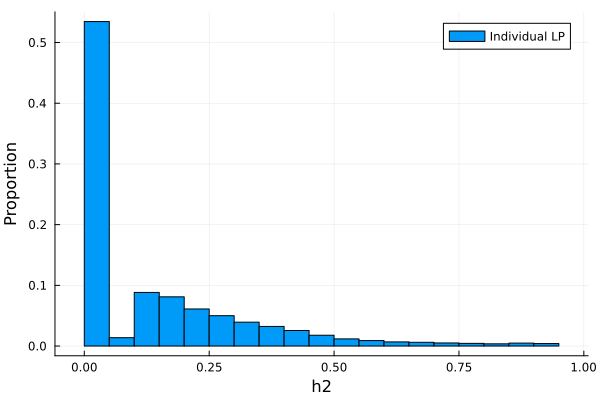

In [52]:
hist_ind = histogram(h2_distr_ind, normalize = :probability,
          label = "Individual LP", xlab = "h2", ylab = "Proportion", bins = 0.0:0.05:0.95)

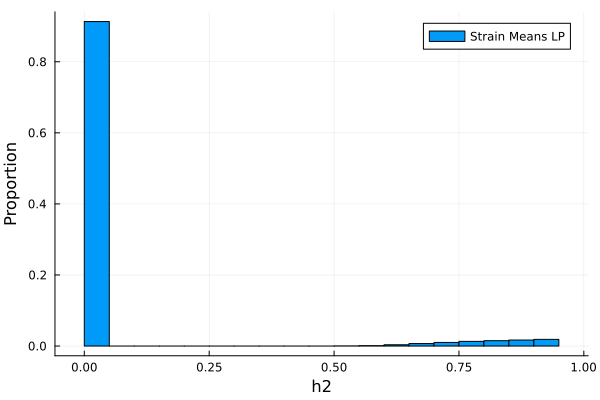

In [53]:
hist_strains = histogram(h2_distr_strains, normalize = :probability,
          label = "Strain Means LP", xlab = "h2", ylab = "Proportion", bins = 0.0:0.05:0.95)

## Run GEMMA for single-trait scans:

In [61]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [59]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

"/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [60]:
run(`$gemma -h`)

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021

 type ./gemma -h [num] for detailed help
 options: 
  1: quick guide
  2: file I/O related
  3: SNP QC
  4: calculate relatedness matrix
  5: perform eigen decomposition
  6: perform variance component estimation
  7: fit a linear model
  8: fit a linear mixed model
  9: fit a multivariate linear mixed model
 10: fit a Bayesian sparse linear mixed model
 11: obtain predicted values
 12: calculate snp variance covariance
 13: note
 14: debug options

The GEMMA software is distributed under the GNU General Public v3
   -license    show license information
   see also http://www.xzlab.org/software.html, https://github.com/genetics-statistics


Process(`/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64 -h`, ProcessExited(0))

In [86]:
function transform_bxd_pheno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, iter::Int64)
    pheno = CSV.read(inputfile, DataFrame);
    pheno = Matrix{Float64}(pheno[:, 3:end]);
    open(outputfile, "w") do io
        writedlm(io, pheno[:, iter])
    end
    return pheno
end

transform_bxd_pheno_to_gemma2 (generic function with 1 method)

In [187]:
function transform_bxd_geno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, 
                                      startCol::Int64)
    data = CSV.read(inputfile, DataFrame);
    
    marker_names = names(data)[startCol:end];
    data = 2 .* data[:, startCol:end] |> x -> Matrix{Float64}(x)
    # data = data[:, startCol:end] |> x -> Matrix{Float64}(x)
    minor_allele = fill("A", length(marker_names), 1);
    major_allele = fill("B", length(marker_names), 1);
    output = hcat(hcat(marker_names, minor_allele, major_allele), transpose(data))
    writeToFile(output, outputfile)
    return output
end

transform_bxd_geno_to_gemma2 (generic function with 2 methods)

In [188]:
lp_id

7512

In [189]:
transform_bxd_geno_to_gemma2("data/GN886_geno_strains_summary.csv", "data/GN886_geno_strains_summary.txt", 2);
transform_bxd_geno_to_gemma2("data/GN886_geno_summary.csv", "data/GN886_geno_ind_summary.txt", 4);

In [190]:
transform_bxd_pheno_to_gemma2("data/GN886_pheno_strain_means_summary.csv", "data/GN886_pheno_strains_summary.txt", lp_id);
transform_bxd_pheno_to_gemma2("data/GN886_pheno_summary.csv", "data/GN886_pheno_ind_summary.txt", lp_id);

In [191]:
writedlm("data/kinship_strains.txt", kinship_strains, '\t')
writedlm("data/kinship_ind.txt", kinship_ind_from_strains, '\t')

In [192]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

p2lod (generic function with 1 method)

In [193]:
function gemmaWrapper(pheno_filename::String, geno_filename::String,
                      kinship_filename::String, output_filename::String)
    
    run(`$gemma -g $geno_filename -p $pheno_filename -k $kinship_filename -lmm 2 -lmax 1000000 -o $output_filename`)
    
end

gemmaWrapper (generic function with 1 method)

In [194]:
@time gemmaWrapper("data/GN886_pheno_strains_summary.txt", 
                   "data/GN886_geno_strains_summary.txt",
                   "data/kinship_strains.txt",
                   "results_strains.txt");

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 50
## number of analyzed individuals = 50
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =     7321
## number of analyzed SNPs         =     7321
Start Eigen-Decomposition...
pve estimate =nan
se(pve) =nan
================================================== 100%
  0.365461 seconds (488 allocations: 37.438 KiB)


**** INFO: Done.


In [195]:
@time gemmaWrapper("data/GN886_pheno_ind_summary.txt", 
                   "data/GN886_geno_ind_summary.txt",
                   "data/kinship_ind.txt",
                   "results_ind.txt");

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 248
## number of analyzed individuals = 248
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =     7321
## number of analyzed SNPs         =     7321
Start Eigen-Decomposition...
pve estimate =0.0412493
se(pve) =0.0388801


**** WARNING: Matrix G has 199 eigenvalues close to zero


================================================== 100%
  1.881626 seconds (846 allocations: 64.094 KiB)


**** INFO: Done.


In [218]:
sum(eigen(kinship_ind_from_strains).values.<0.0001)

198

In [197]:
gemma_results_strains = readdlm("output/results_strains.txt.assoc.txt", '\t');
gemma_results_ind = readdlm("output/results_ind.txt.assoc.txt", '\t');

In [198]:
gemma_strains = gemma_results_strains[2:end, 10] |> x -> Array{Float64}(x);
gemma_ind = gemma_results_ind[2:end, 10] |> x -> Array{Float64}(x);

In [199]:
gemma_strains_lod = p2lod.(gemma_strains, 1);
gemma_ind_lod = p2lod.(gemma_ind, 1);

In [200]:
hcat(gemma_strains_lod, scan_results_strains.lod)

7321×2 Matrix{Float64}:
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.196429  0.0175979
 0.339334  0.018276
 ⋮         
 0.759389  1.12186
 0.759389  1.12186
 0.759389  1.12186
 0.86283   1.074
 0.704678  0.988229
 0.704678  0.988229
 0.643452  1.03307
 0.70019   1.12923
 0.643452  1.03307
 0.70019   1.12923
 0.347407  0.853909
 0.347407  0.853909

In [210]:
hcat(gemma_ind_lod, scan_results_ind.lod)

7321×2 Matrix{Float64}:
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.000691335  0.232074
 0.0493123    0.224382
 ⋮            
 0.0765058    0.686866
 0.0765058    0.686866
 0.0765058    0.686866
 0.239938     0.625
 0.359364     0.516825
 0.359364     0.516825
 0.248045     0.554568
 0.283795     0.589717
 0.248045     0.554568
 0.283795     0.589717
 0.199538     0.457387
 0.199538     0.457387

In [225]:
lookRange = 2001:4000

2001:4000

In [231]:
lookRange = 1:7321

1:7321

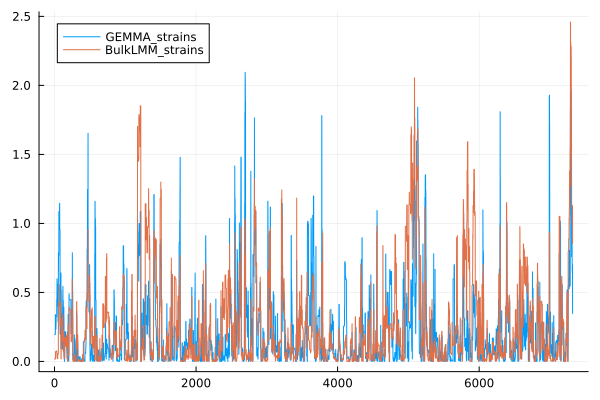

In [232]:
plot(gemma_strains_lod[lookRange], label = "GEMMA_strains");
plot!(scan_results_strains.lod[lookRange], label = "BulkLMM_strains")

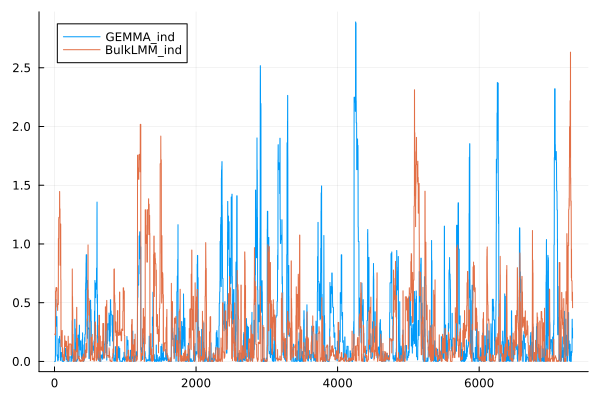

In [234]:
plot(gemma_ind_lod[lookRange], label = "GEMMA_ind");
plot!(scan_results_ind.lod[lookRange], label = "BulkLMM_ind")
# plot!(bulkscan_results_ind[3][lookRange, lp_id], label = "BulkLMM_ind_grid")

In [213]:
scan_results_strains_alt.lod

7321-element Vector{Float64}:
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.23225356131954164
 -0.20338372647907993
  ⋮
  1.1218590379272866
  1.1218590379272866
  1.1218590379272866
  1.0740009400657125
  0.988228626611079
  0.988228626611079
  1.0330695940989103
  1.1292342006500573
  1.0330695940989103
  1.1292342006500573
  0.8539088796289366
  0.8539088796289366

In [214]:
scan_results_ind_alt.lod

7321-element Vector{Float64}:
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.23215073936511893
 0.22444063281062027
 ⋮
 0.7009067564359356
 0.7009067564359356
 0.7009067564359356
 0.6366753494558135
 0.5238690936290965
 0.5238690936290965
 0.5623773261983149
 0.5988737441003279
 0.5623773261983149
 0.5988737441003279
 0.4673744115184242
 0.4673744115184242